In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons
from sklearn import linear_model, datasets

# Analysis

In [10]:
# données simulées du TME2
X1, Y1 = make_classification(n_samples=200, n_features=2, n_redundant=0, n_informative=2,n_clusters_per_class=1)
X2, Y2 = make_blobs(n_samples=200, n_features=2, centers=3)
X3, Y3 = make_moons(n_samples=200, shuffle=True, noise=None, random_state=None)

Xs = [X1,X2,X3]
Ys = [Y1,Y2,Y3]

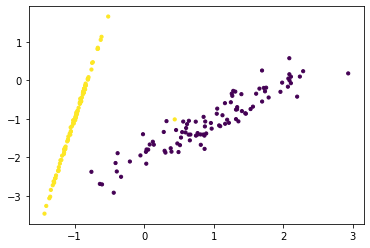

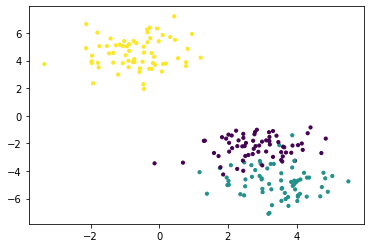

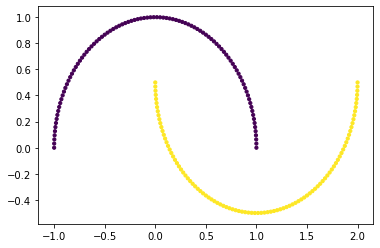

In [20]:
#show datasets
for X, Y in zip(Xs,Ys):
    plt.scatter(X[:, 0], X[:, 1], s=10, c=Y)
    plt.show()

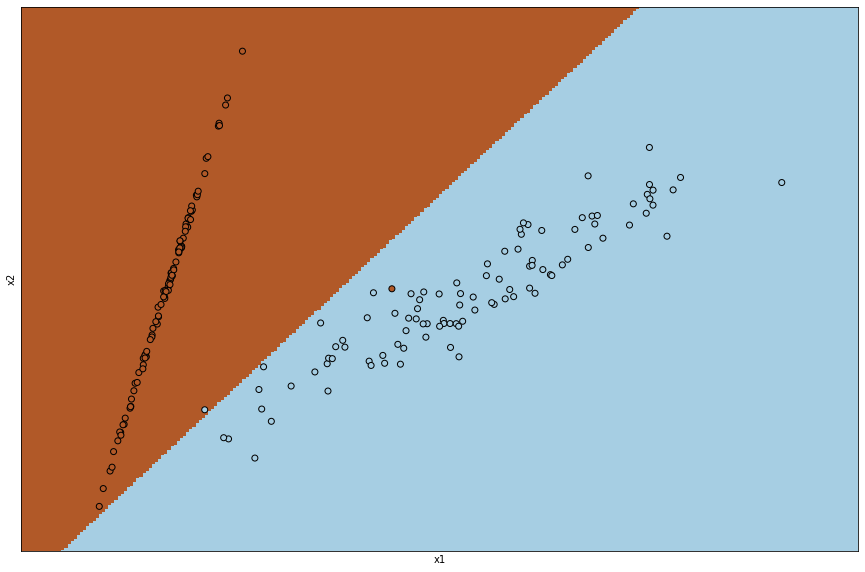

/home/alex/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


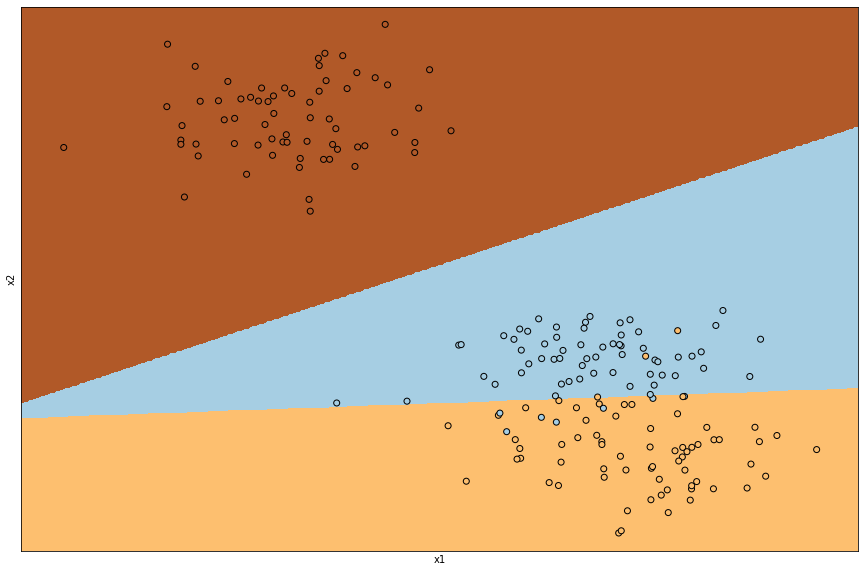

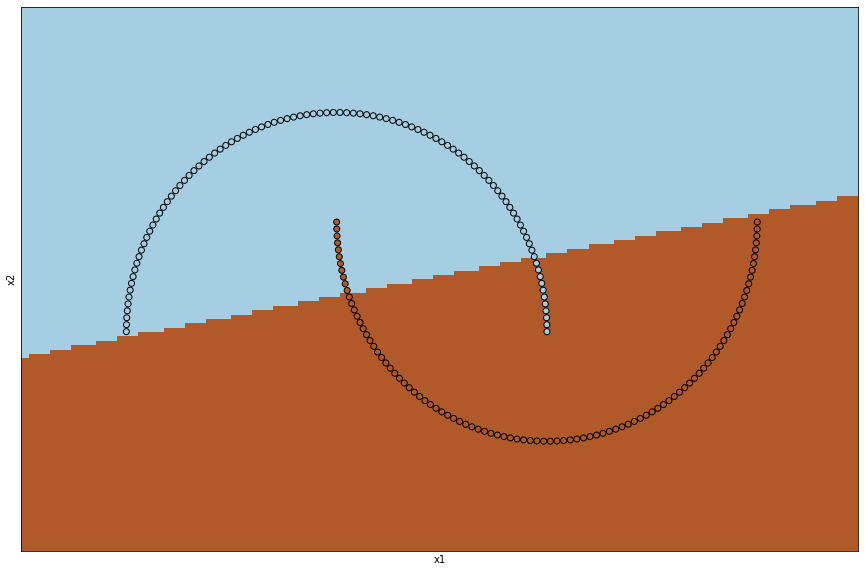

In [48]:
# boundaries on learning set
logreg = linear_model.LogisticRegression(C=1e5, solver='lbfgs')

for X, Y in zip(Xs,Ys):
    logreg.fit(X, Y)
    
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = .02  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])
    
    
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1, figsize=(15, 10))
    plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)
    
    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)
    plt.xlabel('x1')
    plt.ylabel('x2')

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())

    plt.show()
    
    

In [52]:
def split_data(data, k):
    chunks = [None]*k
    c_size = int(len(data) / k)
    for i in range(k):
        chunks[i] = data[i*c_size:(i+1)*c_size]
    return chunks

def cross_validation(X,Y, k, method):
    data = list(zip(X,Y))
    chunks = split_data(data,k)
    scores = []
    for i in range(len(chunks)):
        test_data = chunks[i].copy()
        test_X, test_y = zip(*test_data)

        train_chunks = [chunks[c].copy() for c in range(len(chunks)) if(c != i)]
        train_data = []
        for tc in train_chunks:
            train_data.extend(tc)
            
        train_X, train_y = zip(*train_data)

        method.fit(train_X, train_y)
        prediction = method.predict(test_X)

        score = sum( [1 if(y == y_est) else 0 for y,y_est in zip(test_y, prediction)] ) / len(test_y)
        scores.append(score)
    
    return np.mean(scores) 



In [59]:
# k-fold precision
logreg = linear_model.LogisticRegression(C=1e5, solver='lbfgs')

for X, Y, name in zip(Xs,Ys, ["linear", "blobs", 'moons']):
    print(name + ": " + str(cross_validation(X,Y,5,logreg)) )
    

linear: 0.975
blobs: 0.9450000000000001
moons: 0.875


/home/alex/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/alex/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/alex/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/alex/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/alex/.local/lib/py

# Custom logistic regression

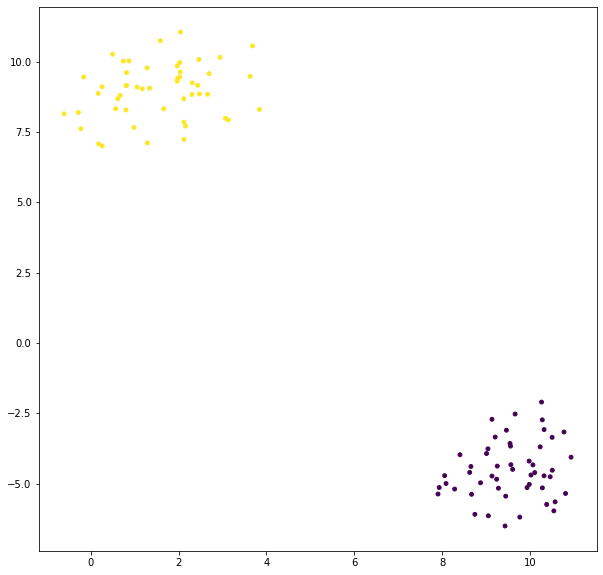

In [363]:
X, Y = make_blobs(n_samples=100, n_features=2, centers=2)
plt.figure(figsize=(10,10))
plt.scatter(X[:, 0], X[:, 1], s=15, c=Y)
plt.show()

In [383]:
def log_likelihood(X,Y,theta):
    weighted_feat = theta.dot(X.T)
    return -sum( Y*weighted_feat - np.log(1 + np.exp(weighted_feat)) )

def prob_0(x,theta):
    return 1/(1+np.exp(theta.dot(x)))

def prob_1(x,theta):
    return np.exp(theta.dot(x)/(1+np.exp(theta.dot(x))))
    
def predict(X,theta):
    #data = np.array(list(zip(X,Y))).T
    #y_est = np.where(data[1]==1, prob_1(data[0],theta) , prob_1(data[0],theta) )
    y_est = []
    for x in X:
        scores = np.array([prob_0(x,theta),prob_1(x,theta)])
        y_est.append(np.argmax(scores))
    return np.array(y_est)

def gradient_1(X,Y,theta):
    y_est = prob_1(X.T,theta) # p(y=1|x)
    grad = []
    for x, y, y_hat in zip(X,Y,y_est):
        grad.append(x*(y-y_hat))
    return -sum(grad) # 1 x p
    
def gradient_2(X,Y,theta):
    y_est = prob_1(X.T,theta) # p(y=1|x)
    grad = []
    for x, y_hat in zip(X,y_est):
        mat = np.zeros((len(x),len(x)))
        for i in range(len(x)):
            for j in range(len(x)):
                mat[i,j] = x[i] * x.T[j]
        
        grad.append(mat*y_hat*(1-y_hat))
    return sum(np.array(grad)) # p x p

In [384]:
theta = np.zeros(np.size(X,1))

print(log_likelihood(X,Y,theta))
print(predict(X,theta))

print(gradient_1(X,Y, theta))
print(gradient_2(X,Y, theta))

69.31471805599459
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[ 477.99486176 -225.53513438]
[[0. 0.]
 [0. 0.]]


In [394]:
from numpy.linalg import LinAlgError

def gradient_descent(X,Y, alph=0.1, max_iter=100):
    theta = np.zeros(np.size(X,1))
    ll = log_likelihood(X,Y,theta)
    for t in range(max_iter):
        grad_2 = gradient_2(X,Y, theta)
        grad_1 = gradient_1(X,Y, theta)
        try:
            theta = theta - alph * np.linalg.inv(grad_2).dot(grad_1)
        except LinAlgError: #add small noise
            grad_2 = grad_2+1e-10*np.random.rand(grad_2.shape[0], grad_2.shape[1])
            theta = theta - alph * np.linalg.inv(grad_2).dot(grad_1)
        n_ll = log_likelihood(X,Y,theta)
        print(theta, n_ll)
        
        
gradient_descent(X,Y)

/home/alex/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/home/alex/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':


[-1.12937774e+13  1.17518612e+13] inf
[-1.12937774e+13  1.17518612e+13] inf
[-1.12937774e+13  1.17518612e+13] inf
[-1.12937774e+13  1.17518612e+13] inf
[-1.12937774e+13  1.17518612e+13] inf
[-1.12937774e+13  1.17518612e+13] inf
[-1.12937774e+13  1.17518612e+13] inf
[-1.12937774e+13  1.17518612e+13] inf
[-1.12937774e+13  1.17518612e+13] inf
[-1.12937774e+13  1.17518612e+13] inf
[-1.12937774e+13  1.17518612e+13] inf
[-1.12937774e+13  1.17518612e+13] inf
[-1.12937774e+13  1.17518612e+13] inf
[-1.12937774e+13  1.17518612e+13] inf
[-1.12937774e+13  1.17518612e+13] inf
[-1.12937774e+13  1.17518612e+13] inf
[-1.12937774e+13  1.17518612e+13] inf
[-1.12937774e+13  1.17518612e+13] inf
[-1.12937774e+13  1.17518612e+13] inf
[-1.12937774e+13  1.17518612e+13] inf
[-1.12937774e+13  1.17518612e+13] inf
[-1.12937774e+13  1.17518612e+13] inf
[-1.12937774e+13  1.17518612e+13] inf
[-1.12937774e+13  1.17518612e+13] inf
[-1.12937774e+13  1.17518612e+13] inf
[-1.12937774e+13  1.17518612e+13] inf
[-1.12937774